In [1]:
import numpy as np
import matplotlib.pyplot as plt
import importlib
import scipy.stats as stats
import numpy.linalg as LA
import glob as glob
import matplotlib as mpl
# set figure defaults
mpl.rcParams['figure.dpi'] = 150
plt.rcParams['figure.figsize'] = (12.0/2, 12.0/2)

import xarray as xr
import pandas as pd

from matplotlib.patches import Polygon
import matplotlib as mpl
import cartopy
import cartopy.io.shapereader as shpreader
import cartopy.feature as cfeat
import cartopy.crs as ccrs

In [2]:
MS = 12
FS = 10

inc = 0.2
MULT_FACT = 12

[[-0.63333333  0.33333333]
 [ 1.36666667 -1.66666667]
 [-0.73333333  1.33333333]]
[(-0.6333333333333333, 1.3666666666666667, -0.7333333333333334), (0.33333333333333337, -1.6666666666666665, 1.3333333333333335)]
C [[ 0.93555556 -1.15555556]
 [-1.15555556  1.55555556]]
E [[-0.79344421  0.60864298]
 [-0.60864298 -0.79344421]]
eigenvalue:  [0.04914064 2.44197047]
[[ 0.29963367 -0.64995529]
 [-0.06996878  2.1542191 ]
 [-0.22966489 -1.5042638 ]]


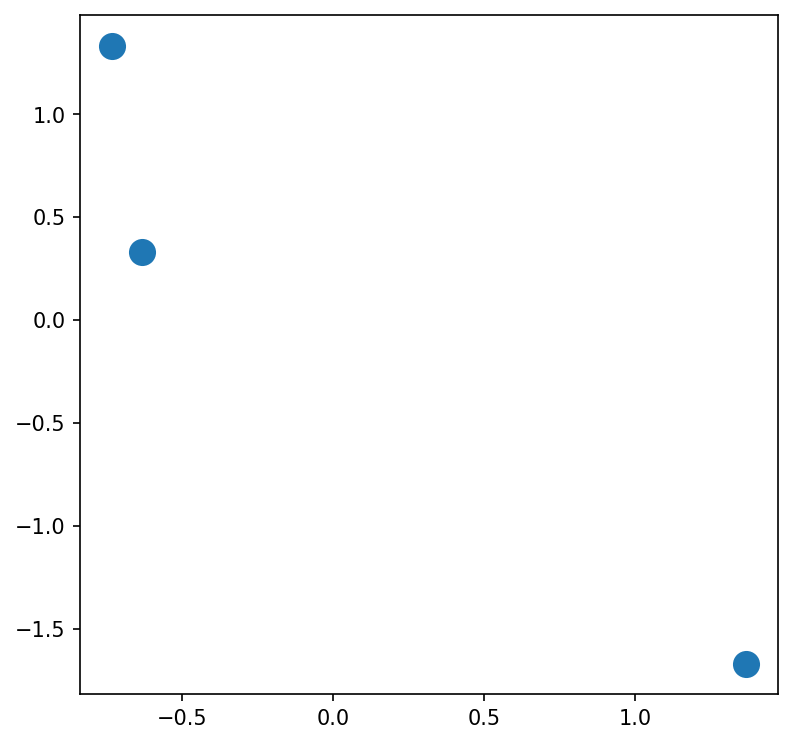

In [3]:
# Test for eigenanalysis

A = [[-1, 1],[1, -1],[-1.1, 2]]  # , [2,3]
A = np.asarray(A)
A = A - np.mean(A, axis=0)


print(A)
print(list(zip(*A)))
plt.plot(list(zip(*A))[0], list(zip(*A))[1], linestyle = '', marker = 'o', markersize  = MS)

# Do eigenanalysis: 
C= np.cov(A, rowvar = False, bias = True)
print('C', C)

# eigendecompose

LAM, E = LA.eig(C)  # LAM: eigen value; E: eigen matrix
print('E', E)
print('eigenvalue: ', LAM)

A_new = np.dot(A, E)
# print(E[1])
print(A_new)

# explained variance:
var_exp = 100.* LAM[0] /np.sum(LAM)  # in percent %

## Problem 1 of 1: EOF analysis  

### Option (C): My own data:  Description of my data:  

The data used here is the monthly mean liquid water path (LWP, unit in $g*m^{-2}$) in 5 X 5$^{o}$ averaged grid boxes of the Southern Ocean region (40 ~ 85$^{o}$ S) from climate model simulation. So the raw data has grid point for lat X lon = 10 x 73.  

Two experiments data of LWP shows here, one is the 'piControl' experiment, corresponding to the pre-industrial condition of greenhouse gas and all other meteorological conditions. Another experiment is the 'abrupt-4xCO2' exp, which cooresponding to the conditions after quadrupling the CO2 concentration of pre-indutrial level. Each experiment has the simulation for 99 years and 300 years, so 99x12 =1188 and 300x12 +1 = 3601 months. The 'abrupt-4xCO2' experiment was used for eigenanalysis.  

For analyzing purpose, the raw data with 3-dimensions (Times x Lat x Lon) would be reshaped into 2 dimensions for: Times (M = 1188) x Spatial (N = 730) during the eigenanalysis.

M is the length of sampling dimension;  

and N is the length of structure dimension.

In [62]:
# Read my own data:
exp = 'abrupt-4xCO2'
CESM2 = {'modn': 'CESM2', 'consort': 'NCAR', 'cmip': 'cmip6',
         'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}

path1 = '/glade/work/chuyan/Research/Cloud_CCFs_RMs/plots_test1/'
path7 = '/glade/work/chuyan/Research/Cloud_CCFs_RMs/Course_objective_ana/'


# output_ARRAY_best4 = {}
# output_intermedia_best4 = {}
# output_dict0_PI_best4 =  {}
# output_dict0_abr_best4 = {}
output_4lrm_mon_bin_abr =  {}
output_4lrm_mon_bin_PI  =  {}

folder_4lrm =  glob.glob(path1 + CESM2['modn']+ '_best(test6)fit_' + '*K'+'_ud' + '*' + '_dats.npz')
print(folder_4lrm)

output_ARRAY_best4 =  np.load(folder_4lrm[0], allow_pickle=True)  # str(TR_sst)+str(TR_sub) 
output_intermedia_best4 = output_ARRAY_best4['rawdata_dict']

output_dict0_PI_best4 =   output_intermedia_best4[()]['dict0_PI_var']
output_dict0_abr_best4=   output_intermedia_best4[()]['dict0_abr_var']
# monthly data
LWP_mon_bin_PI  =  1000. *output_dict0_PI_best4['dict1_mon_bin_PI']['LWP_mon_bin']  # Units in : g m^-2
LWP_mon_bin_abr =  1000. *output_dict0_abr_best4['dict1_mon_bin_abr']['LWP_mon_bin']  # Units in : g m^-2

# print(LWP_mon_bin_PI)
print(LWP_mon_bin_abr.shape)

['/glade/work/chuyan/Research/Cloud_CCFs_RMs/plots_test1/CESM2_best(test6)fit_269.42K_ud0.6_dats.npz']
(3601, 10, 73)


(1188, 730)
(730,)


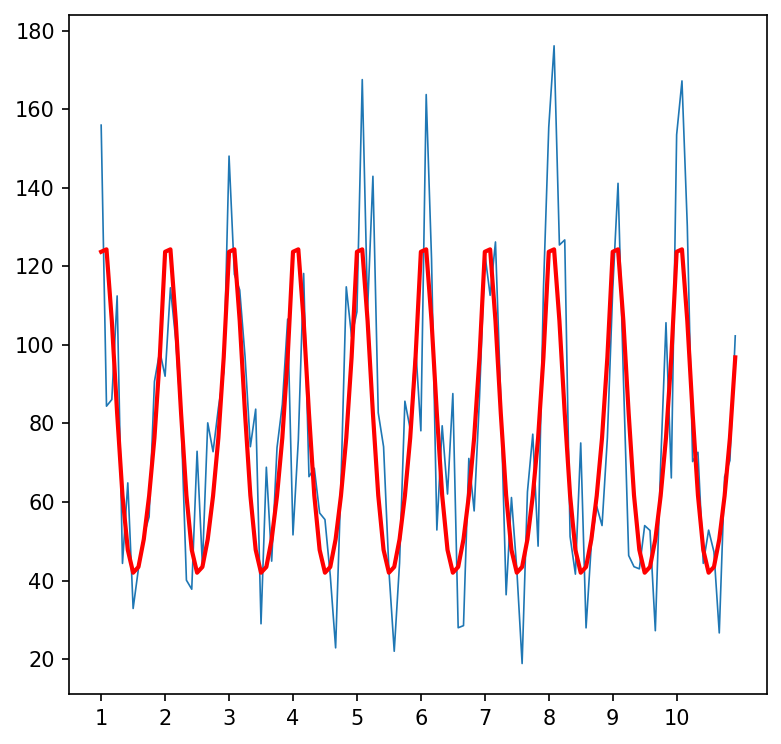

In [71]:
# Data preprocessing:
##  detrend the data

# curve_fit to detrend the annually seasonality:
dr_LWP_mon_bin_PI = np.zeros((LWP_mon_bin_PI.shape[0], LWP_mon_bin_PI.shape[1], LWP_mon_bin_PI.shape[2]))
dr_LWP_mon_bin_abr = np.zeros((LWP_mon_bin_abr.shape[0],LWP_mon_bin_abr.shape[1], LWP_mon_bin_abr.shape[2] )) 

T1 = [i%12 for i in range(0, LWP_mon_bin_PI.shape[0])]

degree =  5
for j in np.arange(LWP_mon_bin_PI.shape[1]):
    for k in np.arange(LWP_mon_bin_PI.shape[2]):
        
        coef = np.polyfit(T1, LWP_mon_bin_PI[:,j,k], degree)
        # create curve
        curve = []
        for i in range(LWP_mon_bin_PI.shape[0]):
            value = coef[-1]
            for d in range(degree):

                value += T1[i]**(degree- d) * coef[d]
            curve.append(value)
        
        dr_LWP_mon_bin_PI[:,j,k] = curve

T2 = [i%12 for i in range(0, LWP_mon_bin_abr.shape[0])]

for j in np.arange(LWP_mon_bin_abr.shape[1]):
    for k in np.arange(LWP_mon_bin_abr.shape[2]):
        
        coef2 = np.polyfit(T2, LWP_mon_bin_abr[:,j,k], degree)
        # create curve
        curve2 = []
        for i in range(LWP_mon_bin_abr.shape[0]):
            value2 = coef2[-1]
            for d in range(degree):

                value2 += T2[i]**(degree-d) * coef2[d]
            curve2.append(value2)
        
        dr_LWP_mon_bin_abr[:,j,k] = curve2
        
# see the seasonality:
plt.plot(np.arange(0, 120), LWP_mon_bin_PI[:120,3,12], linewidth = 0.8)
plt.plot(np.arange(0, 120), dr_LWP_mon_bin_PI[:120,3,12], color='red', linewidth = 2)

plt.xticks(ticks= np.arange(0, 120, 12), labels = np.arange(1, 120/12+1).astype(int))


dr_LWP_mon_bin_PI = LWP_mon_bin_PI - dr_LWP_mon_bin_PI
dr_LWP_mon_bin_abr = LWP_mon_bin_abr - dr_LWP_mon_bin_abr
##  Reshape into M * N
LWP_PI = dr_LWP_mon_bin_PI *1.
LWP_PI = LWP_PI.reshape(1188, 730)

LWP_abr = dr_LWP_mon_bin_abr *1.
LWP_abr = LWP_abr.reshape(3601, 730)
print(LWP_PI.shape)

##  Removing the sampling mean
LWP_PI =  LWP_PI - np.mean(LWP_PI, axis = 0)
LWP_abr =  LWP_abr - np.mean(LWP_abr, axis = 0)

# print(np.mean(LWP_PI, axis =0))

##  Weighting the data
lats = np.arange(-85., -35., 5.)
lons = np.arange(-180., 183, 5.)

X, Y  = np.meshgrid(lons, lats)
weighting_matrix = np.sqrt(np.cos(Y*np.pi /180.)).flatten()

print(weighting_matrix.shape)

w_LWP_PI = np.zeros((LWP_PI.shape[0], LWP_PI.shape[1]))
for q in range(LWP_PI.shape[0]):
    w_LWP_PI[q,:] = (LWP_PI[q,:]*1.) * weighting_matrix
    
w_LWP_abr = np.zeros((LWP_abr.shape[0], LWP_abr.shape[1]))
for w in range(LWP_abr.shape[0]):
    w_LWP_abr[w,:] = (LWP_abr[w,:]*1.) * weighting_matrix


We choose not to standardize the data. Because the structure dimension is actually the spatial dimension, so the units of data are consitent.

### (a)Use Eigendecomposition method for calculating EOF's and PC's:

In [74]:
# Do eigenanalysis: 
C= np.cov(w_LWP_abr, rowvar=False, bias=True)   # covariance matrix
print('C', C.shape)

# Eigendecomposition
LAM, E  = LA.eig(C)  # E: eigenvectors metrix; LAM: eigenvalues at diagonal matrix V

print('E', E)
print('eigenvalue: ', LAM)

# sort the eigenvector and eigenvalue by the order of eigenvalue (largest to smallest):
i = np.flipud(np.argsort(LAM))

LAM  = LAM[i]
E   =  E[:,i]
# print(i)
# print('E', E)

C (730, 730)
E [[ 7.88366941e-03 -2.03402996e-03  7.46068984e-03 ... -4.28757743e-02
  -4.90302466e-02 -9.57988205e-03]
 [ 7.74381329e-03 -1.85687796e-03  7.34679101e-03 ...  2.50510666e-02
  -5.07205602e-02 -4.68094570e-02]
 [ 7.52415417e-03 -1.57233275e-03  6.98031876e-03 ... -3.06756290e-03
   1.27388237e-01  8.73361762e-02]
 ...
 [-5.37488910e-02 -4.89850294e-03  2.34060018e-02 ...  2.07009894e-04
  -2.27496008e-04 -5.05079599e-04]
 [-2.96169318e-02 -8.16327592e-03  1.02658685e-02 ... -4.68505432e-05
  -8.67363788e-05  2.52691079e-04]
 [-3.15619686e-02 -2.67218935e-03  1.58648567e-02 ... -1.17188333e-04
  -1.89466580e-04 -7.07505365e-04]]
eigenvalue:  [2.79371961e+04 1.19870045e+04 1.00560141e+04 8.26644708e+03
 7.85741250e+03 6.92281755e+03 6.39363035e+03 5.42408052e+03
 4.87145407e+03 4.17362500e+03 3.62351807e+03 3.11204888e+03
 2.91161408e+03 2.79182204e+03 2.40890832e+03 2.43810922e+03
 2.12132163e+03 1.93494176e+03 1.85992158e+03 1.80814067e+03
 1.72780122e+03 1.60106004e+03 

### (b)Plot the eigenvalue:

(730,)


Text(0.5, 1.0, 'The largest twenty eigenvalue ')

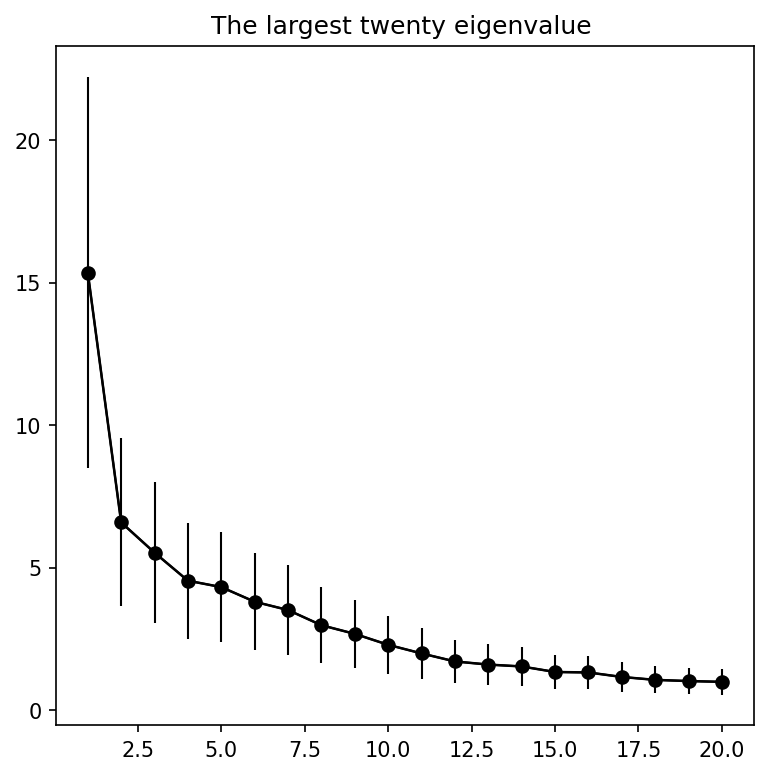

In [93]:
# convert eigenvalues to percent variance explained:

pve  =  100. * LAM/ np.sum(LAM)
print(pve.shape)

# plt.figure(figsize = (9.6))

# Only plot the first 20 eigenvectors

plt.plot(np.arange(1, 21), pve[0:20],'o-', linewidth = 1.2, color = 'black')

# plot error bars according to Nstar = N /12*4. (North et al., 1982)

Nstar = np.size(X, axis = 0) /4.
eb = pve[0:20]* np.sqrt(2./Nstar)
plt. errorbar(np.arange(1, 21), pve[0:20], yerr = eb/2., xerr = None, linewidth = 1, color = 'black')

plt.title("The largest twenty eigenvalue ")

I estimate the degree of freedom equal to the length of sampling dimension (Times) divided by 4. The reason I choose it is the property of LWP data I used. It is a monthly mean data after detrending the seasonal variability, so i didn't divided by 12. However, the spatial dimension is obviously not independent, since I have 730 grid points for the Southern Ocean region, I didn't pick a very large number as the denominator.

### (c)Analyze the leading two EOF's and PC's by project the data (unweighted) onto standardized PC's:  

In [80]:
# which EOF do you want to plot?
eof_num = 1
#===============================

# take only one eigenvector, user specified by "eof_num" above
e1 = E[:,eof_num-1] 

# calculate the the PC associated with the EOF of interest
z1 = np.dot(w_LWP_abr, e1) 

# standardize z1
z1 = (z1-np.nanmean(z1))/np.nanstd(z1)

# calculate d1 for plotting in physical units, not standardized/weighted units
d1 = np.dot(np.matrix(z1), LWP_abr).T/ e1.shape[0]

# calculate d1 for plotting in standardized/weighted units,
# thus it uses the "Xw" anomaly data

# If no NaNs in data, I could use this
# d1s = (1./np.size(Xw, axis = 0))*np.dot(np.transpose(z1),Xw)
# If there ARE NaNs:
d1s = np.dot(np.matrix(z1), w_LWP_abr).T/ LWP_abr.shape[0]

In [81]:
# which EOF do you want to plot?
eof_num = 2
#===============================

# take only one eigenvector, user specified by "eof_num" above
e2 = E[:,eof_num-1] 

# calculate the the PC associated with the EOF of interest
z2 = np.dot(w_LWP_abr,e2) 

# standardize z1
z2 = (z2-np.nanmean(z2))/np.nanstd(z2)

# calculate d1 for plotting in physical units, not standardized/weighted units
d2 = np.dot(np.matrix(z2), LWP_abr).T / e2.shape[0]

# calculate d1 for plotting in standardized/weighted units,
# thus it uses the "Xw" anomaly data

# If no NaNs in data, I could use this
# d1s = (1./np.size(Xw, axis = 0))*np.dot(np.transpose(z1),Xw)
# If there ARE NaNs:
d2s = np.dot(np.matrix(z2), w_LWP_abr).T/ LWP_abr.shape[0]

### (d) plot the EOF's patterns and the leading 2 PC's:  

/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  app.launch_new_instance()


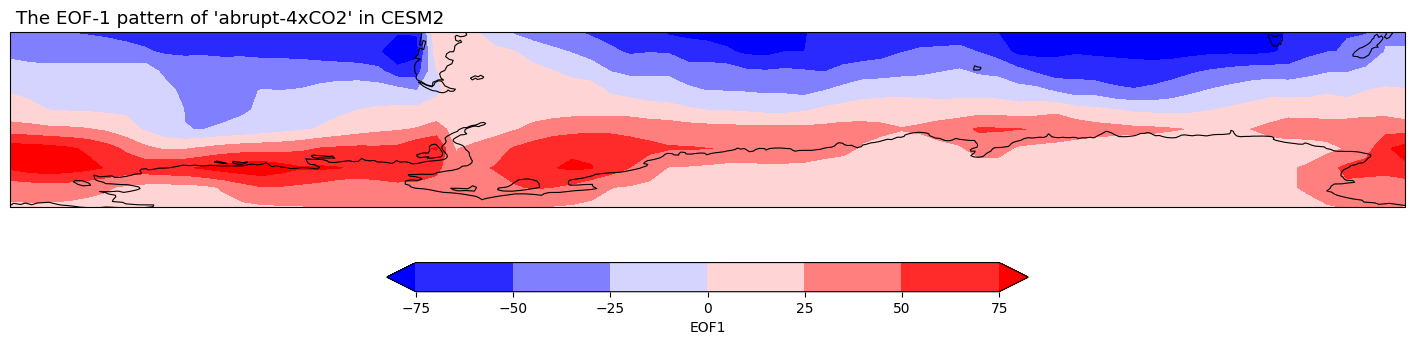

In [86]:
# EOF1 with raw physical units:

EOF1 = d1.reshape(10, 73)

# Plotting the map:

proj= ccrs.PlateCarree()
fig = plt.figure( figsize=(18., 9.5*3), dpi = 100 )
ax1  = plt.subplot(111, projection = proj)

#..map attributes country border, coastline, Rivers, Lakes..
ax1.add_feature(cfeat.COASTLINE.with_scale('110m'), zorder=1, linewidth=0.8)
# clevel = np.arange(0, 5, 1.)

contourf1 = ax1.contourf(X, Y, EOF1, cmap='bwr', extend='both')  # predict_label_LWP_PI[t_PI,:,:]
cb1  = fig.colorbar(contourf1, ax=ax1, orientation='horizontal', label='EOF1', extend='both', shrink= 0.46, pad=0.026)

# contourf2 = ax1[1].contourf(X, Y, EOF2, levels= clevel, cmap='seismic', extend='both')
# cb2  = fig.colorbar(contourf2, ax=ax1[1], orientation='vertical', label='# of regime', extend='both', shrink=0.14, pad=0.03)


# ax1.set_title(" The EOF-1 pattern of 'piControl' in CESM2 ", fontsize=12* 1.1, loc='left')
ax1.set_title(" The EOF-1 pattern of 'abrupt-4xCO2' in CESM2 ", fontsize=12* 1.1, loc='left')
plt.show()

/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  app.launch_new_instance()


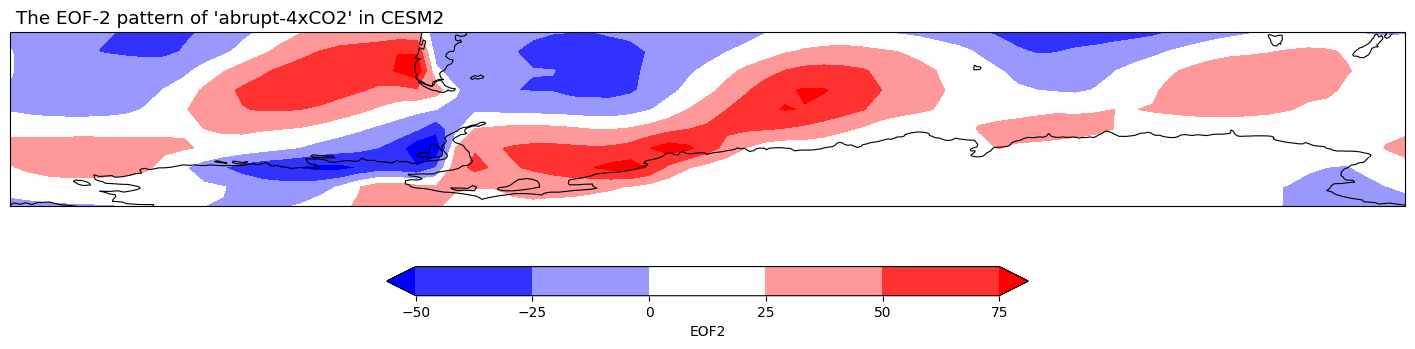

In [87]:
# EOF2 with raw physical units:

EOF2 = d2.reshape(10, 73)

# Plotting the map:

proj= ccrs.PlateCarree()
fig = plt.figure( figsize=(18., 9.5*3), dpi = 100 )
ax1  = plt.subplot(111, projection = proj)

#..map attributes country border, coastline, Rivers, Lakes..
ax1.add_feature(cfeat.COASTLINE.with_scale('110m'), zorder=1, linewidth=0.8)
# clevel = np.arange(0, 5, 1.)

contourf1 = ax1.contourf(X, Y, EOF2, cmap='bwr', extend='both')  # predict_label_LWP_PI[t_PI,:,:]
cb1  = fig.colorbar(contourf1, ax=ax1, orientation='horizontal', label='EOF2', extend='both', shrink= 0.46, pad=0.028)


# ax1.set_title(" The EOF-2 pattern of 'piControl' in CESM2 ", fontsize=12* 1.1, loc='left')
ax1.set_title(" The EOF-2 pattern of 'abrupt-4xCO2' in CESM2 ", fontsize=12* 1.1, loc='left')
plt.show()

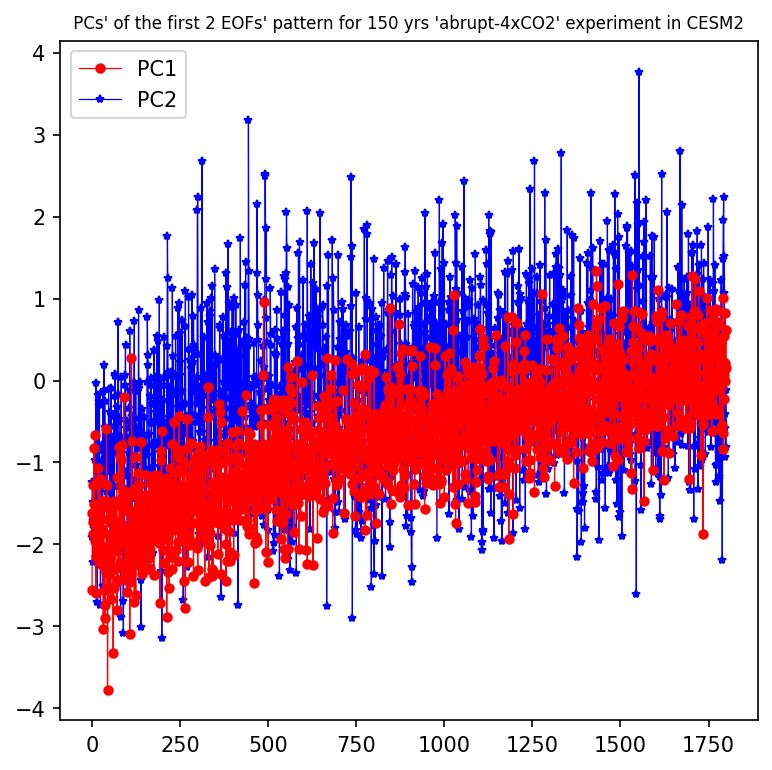

In [92]:
# Principle component as a time series for EOF's 1 and 2:

line1 = plt.plot(np.arange(0, LWP_abr.shape[0]/2), z1[:1801], marker = 'o', color = 'red',linewidth = 0.6,markersize=4, label = 'PC1', zorder = 1)  # predict_label_LWP_PI[t_PI,:,:]
line2 = plt.plot(np.arange(0, LWP_abr.shape[0]/2), z2[:1801], marker = '*', color = 'blue',linewidth = 0.6,markersize=4, label = 'PC2',zorder = 0)
# contourf2 = ax1[1].contourf(X, Y, EOF2, levels= clevel, cmap='seismic', extend='both')
plt.title(" PCs' of the first 2 EOFs' pattern for 150 yrs 'abrupt-4xCO2' experiment in CESM2 ", fontsize=8*1.0)
plt.legend(loc = 'upper left')
# plt.title(" PCs' of the first 2 EOFs' pattern for 150 yrs of 'piControl' experiment in CESM2 ", fontsize=8*1.0)


plt.show()

### (e)dicuss my results on the first two EOF's and PC's  

EOF1 represents the LWP response pattern to the warming in SO, which causing the LWP increases in the colder Southern Ocean (Southern) and decreases in the sub-tropical to extra-tropical transition band of the Southern Ocean. EOF2 has much smaller explained variance and is not significant from North et al., 1982. But it seems shows the mid-latitude cyclone activities, which the positive anomalous of LWP are along the storm track. The PCs' of them show that the strength of cyclone activities seems to be stronger with further warming, but the first EOF's pattern weakening with time, which is quite interesting and I still not have an explanation.    

## end